**Executed:** Mon Oct  3 17:08:03 2016

**Duration:** 4 seconds.

# Multi-spot Gamma Fitting

In [1]:
from fretbursts import fretmath

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

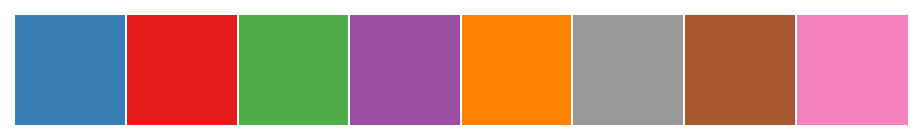

In [3]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

In [4]:
sns.set_style('whitegrid')

# Load Data

## Multispot

Load the **leakage coefficient** from disk (computed in [Multi-spot 5-Samples analyis - Leakage coefficient fit](Multi-spot 5-Samples analyis - Leakage coefficient fit.ipynb)):

In [5]:
leakage_coeff_fname = 'results/Multi-spot - leakage coefficient KDE wmean Dem.csv'
leakageM = np.loadtxt(leakage_coeff_fname, ndmin=1)

print('Multispot Leakage Coefficient:', leakageM)

Multispot Leakage Coefficient: [ 0.0334]


Load the **direct excitation coefficient** ($d_{dirT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [6]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_t beta.csv'
dir_ex_t = np.loadtxt(dir_ex_coeff_fname, ndmin=1)

print('Direct excitation coefficient (dir_ex_t):', dir_ex_t)

Direct excitation coefficient (dir_ex_t): [ 0.04932]


Multispot PR for FRET population:

In [7]:
mspot_filename = 'results/Multi-spot - dsDNA - PR - all_samples all_ch.csv'

E_pr_fret = pd.read_csv(mspot_filename, index_col=0)
E_pr_fret

,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.866766,0.872245,0.838805,0.843370,0.835858,0.858535,0.840360,0.846814
12d,0.589120,0.580325,0.572867,0.574415,0.563134,0.555029,0.565811,0.563246
17d,0.297846,0.287886,0.276148,0.279504,0.283104,0.284872,0.271156,0.271861
22d,0.133968,0.131691,0.124933,0.126694,0.119514,0.124942,0.122458,0.129830
27d,0.087183,0.091312,0.079124,0.082680,0.077164,0.084574,0.077923,0.082638


## usALEX

Corrected $E$ from μs-ALEX data:

In [8]:
data_file = 'results/usALEX-5samples-E-corrected-all-ph.csv'
data_alex = pd.read_csv(data_file).set_index('sample')#[['E_pr_fret_kde']]
data_alex.round(6)

,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,nt_mean
sample,,,,,,,,,,,,,
7d,1172,587,542,0.9290,0.924307,0.060130,0.002583,0.5520,0.550744,0.099172,0.004260,0.0022,22.227823
12d,1307,329,948,0.7398,0.727043,0.092062,0.002990,0.5758,0.558745,0.105387,0.003423,0.0154,22.002399
17d,2489,464,1964,0.4268,0.422624,0.112952,0.002549,0.5462,0.539604,0.112457,0.002538,0.0124,21.193171
22d,2054,320,1672,0.1774,0.181067,0.077181,0.001888,0.5458,0.547034,0.114990,0.002812,0.0000,23.016538
27d,791,160,589,0.0826,0.083971,0.069304,0.002856,0.5208,0.561290,0.114456,0.004716,-0.0088,16.830070


In [9]:
E_alex = data_alex.E_gauss_w
E_alex

sample
7d     0.924307
12d    0.727043
17d    0.422624
22d    0.181067
27d    0.083971
Name: E_gauss_w, dtype: float64

# Multi-spot gamma fitting

In [10]:
import lmfit

In [11]:
def residuals(params, E_raw, E_ref):
    gamma = params['gamma'].value
    # NOTE: leakageM and dir_ex_t are globals
    return E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, leakage=leakageM, gamma=gamma, dir_ex_t=dir_ex_t)

In [12]:
params = lmfit.Parameters()
params.add('gamma', value=0.5) 

In [13]:
E_pr_fret_mean = E_pr_fret.mean(1)
E_pr_fret_mean

Sample
7d     0.850344
12d    0.570493
17d    0.281547
22d    0.126754
27d    0.082825
dtype: float64

In [14]:
m = lmfit.minimize(residuals, params, args=(E_pr_fret_mean, E_alex))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    gamma:   0.43034181 +/- 0.011894 (2.76%) (init= 0.5)


In [15]:
E_alex['12d'], E_pr_fret_mean['12d']

(0.72704299999999999, 0.57049340585342045)

In [16]:
m = lmfit.minimize(residuals, params, args=(np.array([E_pr_fret_mean['12d']]), np.array([E_alex['12d']])))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    gamma:   0.45524990 +/- inf      (inf%) (init= 0.5)


In [17]:
print('Fitted gamma(multispot):', m.params['gamma'].value)

Fitted gamma(multispot): 0.455249902347


In [18]:
multispot_gamma = m.params['gamma'].value
multispot_gamma

0.45524990234687851

In [19]:
E_fret_mch = fretmath.correct_E_gamma_leak_dir(E_pr_fret, leakage=leakageM, dir_ex_t=dir_ex_t, 
                                               gamma=multispot_gamma)
E_fret_mch

,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.931042,0.934104,0.915083,0.917727,0.913368,0.926402,0.915985,0.919712
12d,0.742568,0.735293,0.729046,0.730349,0.720786,0.713811,0.723070,0.720881
17d,0.435365,0.421750,0.405360,0.410085,0.415119,0.417578,0.398272,0.399278
22d,0.171434,0.167059,0.153938,0.157378,0.143267,0.153955,0.149082,0.163466
27d,0.076653,0.085453,0.059219,0.066955,0.054927,0.071045,0.056591,0.066864


In [20]:
E_fret_mch.to_csv('results/Multi-spot - dsDNA - Corrected E - all_samples all_ch.csv')

In [21]:
'%.5f' % multispot_gamma

'0.45525'

In [22]:
with open('results/Multi-spot - gamma factor.csv', 'wt') as f:
    f.write('%.5f' % multispot_gamma)

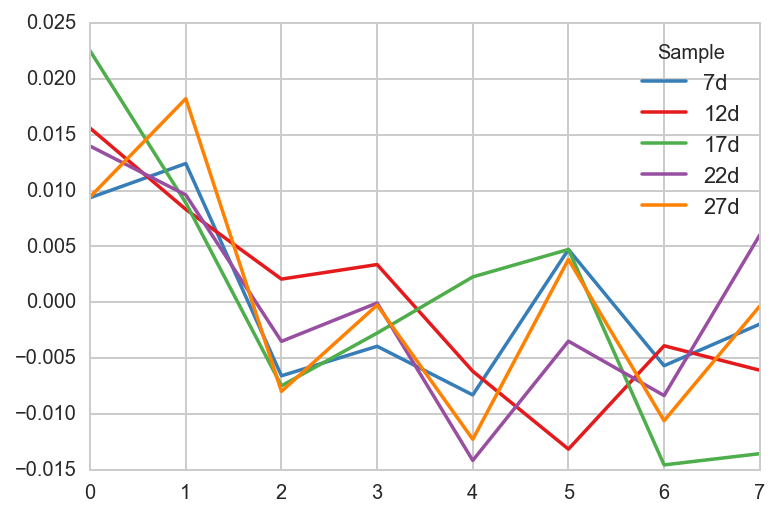

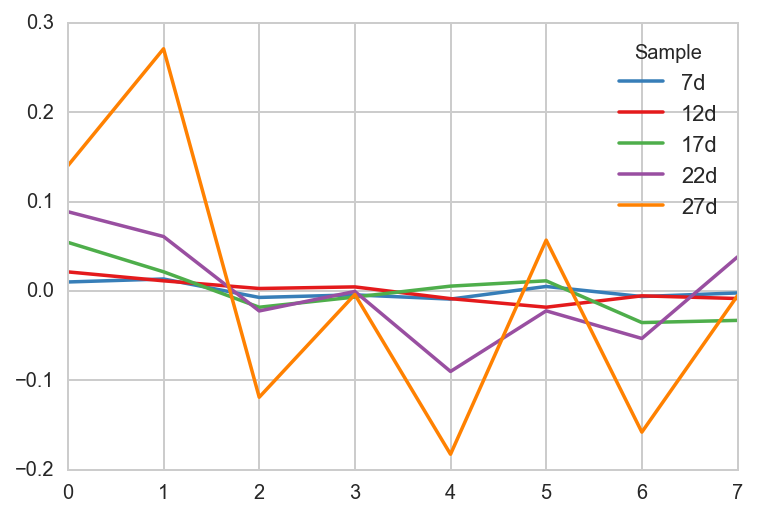

In [23]:
norm = (E_fret_mch.T - E_fret_mch.mean(1))#/E_pr_fret.mean(1)
norm_rel = (E_fret_mch.T - E_fret_mch.mean(1))/E_fret_mch.mean(1)
norm.plot()
norm_rel.plot()

### Plot FRET vs distance

In [24]:
sns.set_style('whitegrid')

In [25]:
CH = np.arange(8)
CH_labels = ['CH%d' % i for i in CH]
dist_s_bp = [7, 12, 17, 22, 27]

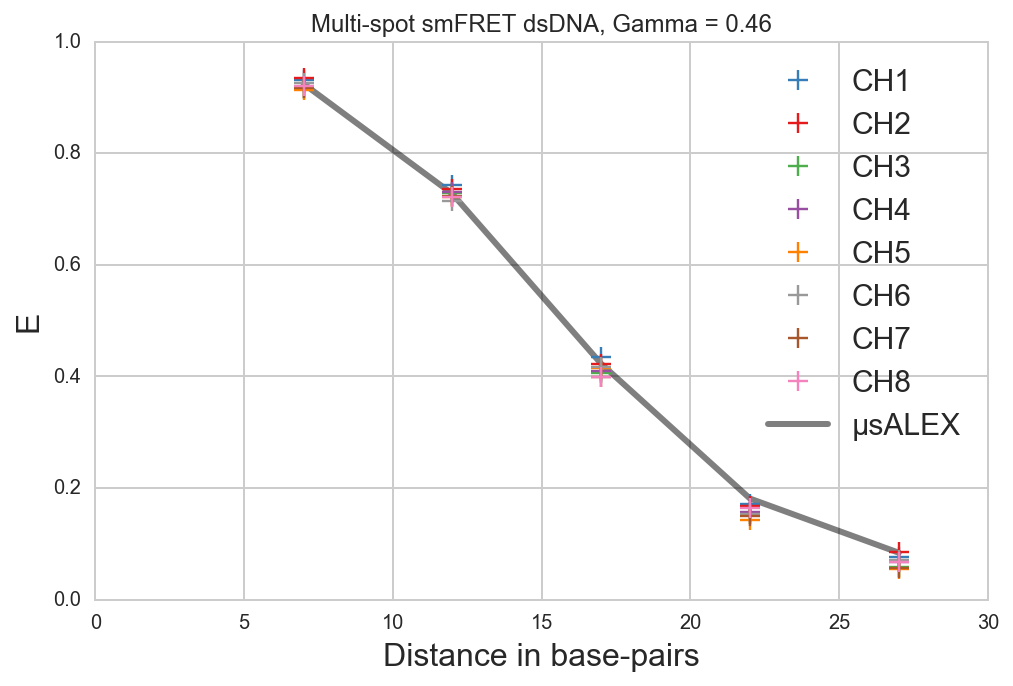

In [26]:
fontsize = 16

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(dist_s_bp, E_fret_mch, '+', lw=2, mew=1.2, ms=10, zorder=4)
ax.plot(dist_s_bp, E_alex, '-', lw=3, mew=0, alpha=0.5, color='k', zorder=3)

plt.title('Multi-spot smFRET dsDNA, Gamma = %.2f' % multispot_gamma)
plt.xlabel('Distance in base-pairs', fontsize=fontsize); 
plt.ylabel('E', fontsize=fontsize)
plt.ylim(0, 1); plt.xlim(0, 30)
plt.grid(True)
plt.legend(['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8', u'μsALEX'], 
       fancybox=True, prop={'size':fontsize-1},
       loc='best');

> **NOTE** The fact the we fit the 27d with a single Gaussian may account for the slight shift of the FRET efficiency compared to the us-ALEX measurements. The shift is bigger when using an asymmetric-gaussian model for multi-spot fitting. Probably, for consistency with us-ALEX fitting we should stick to the plain gaussian.